# Exploring the Gen-3 Butler

<br>Owners: **Alex Drlica-Wagner** ([@kadrlica](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica)), **Douglas Tucker** ([@douglasleetucker](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@douglasleetucker))
<br>Last Verified to Run: **2020-08-10**
<br>Verified Stack Release: **v20.0.0**

## Core Concepts

This notebook provides a first look at the structure and organization of a repo created with the Gen-3 Butler. The Gen-3 Butler is still under development, so this notebook is expected to be updated after the Gen-3 release. For the time being, be sure that you are using the verified version of the stack specified above.

## Learning Objectives:

This notebook lays out features of how the Gen-3 butler functions:

1. Explore a Gen-3 data repo
2. Create a Gen-3 butler
3. Use the Gen-3 butler to explore the ci_hsc_gen3 data repo


In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   20.0.0     	current v20_0_0 setup


In [2]:
# Generic imports
import os,glob
import pylab as plt

In [3]:
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

To generate a data repo that was run with the Gen-3 butler, I used the HSC continuous integration sample. This was generated with code like this:

In [4]:
# Directory where the data repo lives
repo='/project/shared/data/ci_hsc_gen3-w_2020_22/DATA'

You can poke around this directory a bit to see what outputs have been created.

In [5]:
# The base directory for the repo
!ls $repo

butler.yaml  calib  gen3.sqlite3  masks  raw  ref_cats	shared	skymaps  visits


In [6]:
# The outputs are stored in the `shared/ci_hsc_output`
outdir=glob.glob(f'{repo}/shared/ci_hsc_output/*')[0]
!ls $outdir

assembleCoadd_config		deepCoadd_ref_schema
assembleCoadd_metadata		detection_config
calexp				detection_metadata
calexpBackground		forcedPhotCcd_config
calibrate_config		forcedPhotCcd_metadata
calibrate_metadata		forcedPhotCoadd_config
charImage_config		forcedPhotCoadd_metadata
charImage_metadata		forced_src
deblend_config			forced_src_schema
deblend_metadata		icExp
deepCoadd			icExpBackground
deepCoadd_calexp		icSrc
deepCoadd_calexp_background	icSrc_schema
deepCoadd_deblendedFlux		isr_config
deepCoadd_deblendedFlux_schema	isr_metadata
deepCoadd_det			makeWarpTask_config
deepCoadd_det_schema		makeWarpTask_metadata
deepCoadd_directWarp		measure_config
deepCoadd_forced_src		measure_metadata
deepCoadd_forced_src_schema	mergeDetections_config
deepCoadd_meas			mergeDetections_metadata
deepCoadd_measMatch		mergeMeasurements_config
deepCoadd_measMatchFull		mergeMeasurements_metadata
deepCoadd_meas_schema		packages
deepCoadd_mergeDet		postISRCCD
deepCoadd_mergeDet_schema	src
deepCoadd_nImage		

To create the butler you need to pass it a configuration file and a run name. The run name tells the butler where to place output files. More on Butler configuration can be found [here](https://pipelines.lsst.io/modules/lsst.daf.butler/configuring.html). By investigating the directory structue, we find that the 'collection' is `shared/ci_hsc_output`.

In [7]:
butler = dafButler.Butler(repo,collections="shared/ci_hsc_output")

# Optionally, you can specify the repo config explicitly
#config = os.path.join(repo,'butler.yaml')
#butler = dafButler.Butler(config=config,collections="shared/ci_hsc_output")

With the Gen-2 butler, there was no good way to investigate what data exist in a repo. To get around this, we all developed a habit of investigating the directory structure and file names to figure out what data existed.

In [8]:
!ls $outdir/calexp

i  r


In [9]:
!ls $outdir/calexp/r/HSC-R

903334	903336	903338	903342	903344	903346


In [10]:
!ls $outdir/calexp/r/HSC-R/903338

calexp_r_HSC-R_903338_18_HSC_shared_ci_hsc_output_20200810T11h26m26s.fits
calexp_r_HSC-R_903338_25_HSC_shared_ci_hsc_output_20200810T11h26m26s.fits


Based on these filenames, we have enough to specify the dataId to pass to the butler...

In [11]:
dataId = {'visit':903338,'detector':25,'instrument':'HSC'}
calexp = butler.get('calexp', dataId=dataId)

(-0.5, 2047.5, -0.5, 4175.5)

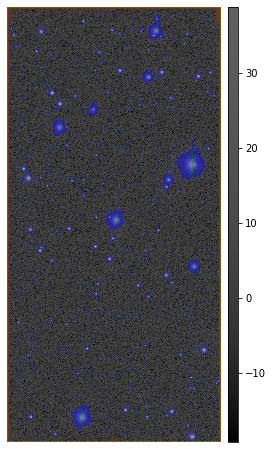

In [12]:
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp)
plt.gca().axis('off')
# And if it wasn't sacrilege I would rotate this image...

## Gen-3 Butler

Ok, so how do we do this in Gen-3 land? Starting from scratch, we want to be able to get going *with only the path to the repo*. 

We can now do this by creating a butler without specifying the collection (since we have no idea what collections exist at this point).

In [13]:
butler = dafButler.Butler(repo)

With the butler created, we can now access the data `registry` (a database containing information about available data products)

In [14]:
registry = butler.registry

# We can examine the registry with
#help(registry)

The `registry` is a good tool for investigating a repo (more on the registry schema can be found [here](https://dmtn-073.lsst.io/)). For example, we can get a list of all collections, which includes the `ci_hsc_output` collection that we were using before.

In [15]:
for c in registry.queryCollections():
    print(c)

calib/hsc
skymaps
raw/hsc
shared/ci_hsc
masks/hsc
ref_cats
shared/ci_hsc_output/20200810T11h26m26s
shared/ci_hsc_output


Now that we "know" that `ci_hsc_output` exists, let's create our butler with this collection:

In [16]:
butler = dafButler.Butler(repo,collections='shared/ci_hsc_output')
registry = butler.registry

We can also use the registry to get a list of all dataset types (for example, we see that `calexp` is available, but that we could also ask directly for `calexp.image` or `calexp.mask`).

In [17]:
for x in registry.queryDatasetTypes():
    print(x)

DatasetType(camera, {instrument, calibration_label}, Camera)
DatasetType(defects, {instrument, calibration_label, detector}, Defects)
DatasetType(bfKernel, {instrument, calibration_label}, NumpyArray)
DatasetType(transmission_optics, {instrument, calibration_label}, TransmissionCurve)
DatasetType(transmission_sensor, {instrument, calibration_label, detector}, TransmissionCurve)
DatasetType(transmission_filter, {abstract_filter, instrument, calibration_label, physical_filter}, TransmissionCurve)
DatasetType(transmission_atmosphere, {instrument}, TransmissionCurve)
DatasetType(deepCoadd_skyMap, {skymap}, SkyMap)
DatasetType(raw, {abstract_filter, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType(brightObjectMask, {abstract_filter, skymap, tract, patch}, ObjectMaskCatalog)
DatasetType(ps1_pv3_3pi_20170110, {htm7}, SimpleCatalog)
DatasetType(jointcal_photoCalib, {abstract_filter, instrument, skymap, detector, physical_filter, tract, visit_system, visit}, PhotoCalib)
D

We suspect that this is all datasetTypes that the processing has *tried* to create during the processing. There may be intermediate products that were created during processing, but no longer exist.

It is now possible to get all `DatasetRef` (including `dataId`) for a specific `datasetType` in a specific collection with a query like the one that follows.

In [18]:
datasetRefs = list(registry.queryDatasets(datasetType='src',collections=['shared/ci_hsc_output']))
for ref in datasetRefs:
    print(ref.dataId)

{instrument: HSC, detector: 10, visit: 903342}
{instrument: HSC, detector: 4, visit: 903342}
{instrument: HSC, detector: 16, visit: 903986}
{instrument: HSC, detector: 100, visit: 903342}
{instrument: HSC, detector: 23, visit: 903986}
{instrument: HSC, detector: 22, visit: 903986}
{instrument: HSC, detector: 5, visit: 903344}
{instrument: HSC, detector: 100, visit: 903986}
{instrument: HSC, detector: 0, visit: 903344}
{instrument: HSC, detector: 11, visit: 903344}
{instrument: HSC, detector: 24, visit: 903988}
{instrument: HSC, detector: 23, visit: 903988}
{instrument: HSC, detector: 17, visit: 903988}
{instrument: HSC, detector: 16, visit: 903988}
{instrument: HSC, detector: 22, visit: 903334}
{instrument: HSC, detector: 4, visit: 904010}
{instrument: HSC, detector: 10, visit: 904010}
{instrument: HSC, detector: 16, visit: 903334}
{instrument: HSC, detector: 100, visit: 903334}
{instrument: HSC, detector: 100, visit: 904010}
{instrument: HSC, detector: 23, visit: 903334}
{instrument: 

Ok, now that we know what collections exist (`shared/ci_hsc_output` in particular), the `datasetTypes` that are defined for that collection, and the `datasetRefs` (which contain `dataIds`) for data products of the requested type. This is all the information that we need to get the dataset of interest!

From the list above, we find that the dataId we were investigating before has index 16

In [19]:
# The dataId that we found before...
ref = datasetRefs[16]
print(ref.dataId)

{instrument: HSC, detector: 10, visit: 904010}


In [20]:
# We could get the src table using the dataId as we did above for the calexp, 
# but this would require the butler to perform another query of the database. 
# Instead, we can just pass the ref itself directly to butler.get
src = butler.get(ref)
src = src.copy(True)
src.asAstropy()

id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,sky_source,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_photometryKron_KronFlux_flag_badInitialCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_

Now to get the `calexp` associated with this exposures and detector we pass the `dataId` to the butler witht the `calexp` datasetType. Note that this performs another query to the registry database to find a calexp that matches our dataId requirements.

In [21]:
# To get the calexp, we pass the dataId
calexp = butler.get('calexp', dataId=ref.dataId)

We can now plot the calexp with the src catalog overlaid. We leave the investigation of this image as an exercise to the user :)

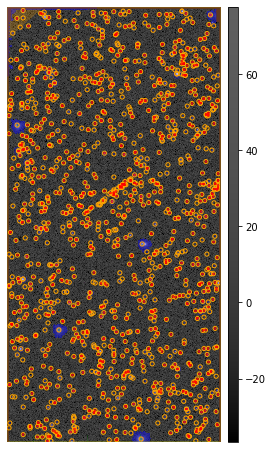

In [22]:
# And plot!
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp)
plt.gca().axis('off')

with afw_display.Buffering():
    for s in src:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange') 

In the case above, both the src and calexp can be found by the registry, but this will not necessarily be the case. The `queryDimensions` method provides a more flexible way to query for multiple datasets (requiring an instance of all datasets to be available for that dataId) or ask for different dataId keys than what is used to identify the dataset (which invokes various built-in relationships). An example of this is provided below:

In [23]:
# Use queryDimensions to provide more flexible access
dataIds = list(registry.queryDimensions(["exposure", "detector"], datasets=["calexp","src"], collections="shared/ci_hsc_output"))
for dataId in dataIds:
    print(dataId)

{instrument: HSC, detector: 10, exposure: 903342, visit: 903342}
{instrument: HSC, detector: 4, exposure: 903342, visit: 903342}
{instrument: HSC, detector: 16, exposure: 903986, visit: 903986}
{instrument: HSC, detector: 100, exposure: 903342, visit: 903342}
{instrument: HSC, detector: 23, exposure: 903986, visit: 903986}
{instrument: HSC, detector: 22, exposure: 903986, visit: 903986}
{instrument: HSC, detector: 5, exposure: 903344, visit: 903344}
{instrument: HSC, detector: 100, exposure: 903986, visit: 903986}
{instrument: HSC, detector: 0, exposure: 903344, visit: 903344}
{instrument: HSC, detector: 11, exposure: 903344, visit: 903344}
{instrument: HSC, detector: 24, exposure: 903988, visit: 903988}
{instrument: HSC, detector: 23, exposure: 903988, visit: 903988}
{instrument: HSC, detector: 17, exposure: 903988, visit: 903988}
{instrument: HSC, detector: 16, exposure: 903988, visit: 903988}
{instrument: HSC, detector: 22, exposure: 903334, visit: 903334}
{instrument: HSC, detector

Now say we wanted to select all detectors with calexp and src datasets associated with a specific filter. We can add that constraint to our query, but first we need to figure out what the filters are called... Looking at the dataId object, we see the attributes `abstract_filter` and `physical_filter` look promising.

In [24]:
dataIds[0].full

IndexedTupleDict({Dimension(abstract_filter): 'r', Dimension(instrument): 'HSC', Dimension(detector): 10, Dimension(physical_filter): 'HSC-R', Dimension(visit_system): 0, Dimension(exposure): 903342, Dimension(visit): 903342})

In [25]:
print(f"physical_filter = {dataId['physical_filter']}")
print(f"abstract_filter = {dataId['abstract_filter']}")

physical_filter = HSC-I
abstract_filter = i


It looks like `abstract_filter` is what we want, so we put it in the `where` argument of `queryDimensions`.

In [26]:
# Use queryDimensions to grab the dataIds for all i-band detectors
dataIds = list(registry.queryDimensions(["exposure", "detector"], datasets=["calexp","src"], where="abstract_filter='i'",collections="shared/ci_hsc_output"))
for dataId in dataIds:
    print(dataId['abstract_filter'], dataId)

i {instrument: HSC, detector: 16, exposure: 903986, visit: 903986}
i {instrument: HSC, detector: 23, exposure: 903986, visit: 903986}
i {instrument: HSC, detector: 22, exposure: 903986, visit: 903986}
i {instrument: HSC, detector: 100, exposure: 903986, visit: 903986}
i {instrument: HSC, detector: 24, exposure: 903988, visit: 903988}
i {instrument: HSC, detector: 23, exposure: 903988, visit: 903988}
i {instrument: HSC, detector: 17, exposure: 903988, visit: 903988}
i {instrument: HSC, detector: 16, exposure: 903988, visit: 903988}
i {instrument: HSC, detector: 4, exposure: 904010, visit: 904010}
i {instrument: HSC, detector: 10, exposure: 904010, visit: 904010}
i {instrument: HSC, detector: 100, exposure: 904010, visit: 904010}
i {instrument: HSC, detector: 25, exposure: 903990, visit: 903990}
i {instrument: HSC, detector: 18, exposure: 903990, visit: 903990}
i {instrument: HSC, detector: 1, exposure: 904014, visit: 904014}
i {instrument: HSC, detector: 6, exposure: 904014, visit: 9040

## Some Exploration

Below is a scratch space for playing with things...